In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

""" DL imports """

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [33]:
ct_path = "/home/jtabalon/airway_seg/test_data/ct_patients10004O.nii"
aw_path = "/home/jtabalon/airway_seg/test_data/aw_10004O.nii"

img = nib.load(ct_path).get_fdata() / 2000.
mask = nib.load(aw_path).get_fdata()

test_img = np.expand_dims(np.expand_dims(img, -1), 0)
test_mask = np.expand_dims(np.expand_dims(mask, -1), 0)

print(img.shape, mask.shape, type(img), type(mask))

(512, 512, 662) (512, 512, 662) <class 'numpy.ndarray'> <class 'numpy.memmap'>


In [34]:
data_dir = "/home/jtabalon/airway_seg_data/train"
patient_id = "10004O"
img_dir = data_dir + "/ct/ct_patients" + str(patient_id) + ".nii"
mask_dir = data_dir + "/labels/aw_" + str(patient_id) + ".nii"

testdir_img = nib.load(ct_path).get_fdata() / 2000.
testdir_mask = nib.load(aw_path).get_fdata()
traindir_img = nib.load(img_dir).get_fdata() / 2000.
traindir_mask = nib.load(mask_dir).get_fdata()

print((testdir_img == traindir_img), (testdir_mask == traindir_mask))



[[[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 [[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 [[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 ...

 [[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  Tr

In [35]:
print(test_img.shape, test_mask.shape)

(1, 512, 512, 662, 1) (1, 512, 512, 662, 1)


In [37]:
np.random.seed(42)

slices = np.sum(test_mask, axis=(0,1,2,4))
len(slices) #662

slices_with_airway = [i for i in range(0, len(slices)) if slices[i] > 0]
print(len(slices_with_airway))

# We just found each slice with airway, now we need to randomly choose a slice.
random_slice_index = np.random.randint(0, len(slices_with_airway))
print(random_slice_index)
random_slice = slices_with_airway[random_slice_index]
print(random_slice)

# Find which columns + rows of the slice contain voxel.

row_column_locations = np.where(test_mask[0,:,:,random_slice,0] > 0)
num_mask_voxels = len(row_column_locations[0]) 
print(num_mask_voxels)

# Randomly choose row/column value
random_row_column_index = np.random.randint(0, num_mask_voxels)
print(random_row_column_index)

random_row = row_column_locations[0][random_row_column_index]
random_column = row_column_locations[1][random_row_column_index]
print(random_row, random_column)

voxel_coordinates = (random_row, random_column, random_slice)
print(voxel_coordinates)

# Extract 64x64x64 patch

img_change = test_img[:, (random_row-32):(random_row+32), \
                  (random_column-32):(random_column+32), \
                  (random_slice-32):(random_slice+32), :]

label_change = test_mask[:, (random_row-32):(random_row+32), \
                  (random_column-32):(random_column+32), \
                  (random_slice-32):(random_slice+32), :]


#print(img.shape, label.shape)

257
102
336
136
92
323 189
(323, 189, 336)


(array([1.0594e+05, 5.2779e+04, 1.2297e+04, 8.3780e+03, 7.4110e+03,
        7.5580e+03, 1.5685e+04, 5.0008e+04, 2.0580e+03, 3.0000e+01]),
 array([-0.512  , -0.44085, -0.3697 , -0.29855, -0.2274 , -0.15625,
        -0.0851 , -0.01395,  0.0572 ,  0.12835,  0.1995 ]),
 <BarContainer object of 10 artists>)

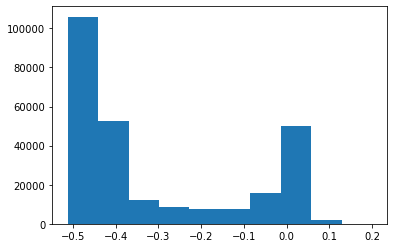

In [38]:
plt.hist(img_change.flatten())

(array([256954.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   5190.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

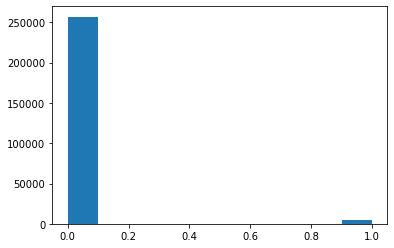

In [39]:
plt.hist(label_change.flatten())

In [40]:
# ids = ["10004O"]
ids = ["10004O", "10055F"]
data_dir = "/home/jtabalon/airway_seg_data/train"
#img_dir = os.path.join(data_dir, r'train/ct/ct_patient' + str(ids[0]) + '.nii')
#img_dir


In [41]:
mask_dir = os.path.join(data_dir, r'train/labels/aw_' + str(ids) + '.nii')
mask_dir

"/home/jtabalon/airway_seg_data/train/train/labels/aw_['10004O', '10055F'].nii"

In [42]:
np.random.seed(42)   

ids = ["10004O"]
data_dir = "/home/jtabalon/airway_seg_data/train"
patch_size = 64
batch_size = 1

# if shuffle:
#     np.random.shuffle(ids)
# num_batches = len(id) / batch_size

patch_distance = int(patch_size / 2)
patch_images = []
patch_labels = []

# Load images
data_dict = dict()
for patient_id in ids:
    # Read in image
    #print(data_dir)
    #img_dir = os.path.join(data_dir, r'/ct/ct_patients' + str(patient_id) + '.nii')
    #img_dir = os.path.join(data_dir, r'/ct/ct_patients' + str(patient_id) + '.nii')
    #print(data_dir)
    mask_dir = os.path.join(data_dir, r'/labels/aw_' + str(patient_id) + '.nii')

    img_dir = data_dir + "/ct/ct_patients" + str(patient_id) + ".nii"
    mask_dir = data_dir + "/labels/aw_" + str(patient_id) + ".nii"

    img = nib.load(img_dir).get_fdata() / 2000.
    mask = nib.load(mask_dir).get_fdata()
    row_dim = img.shape[0]
    column_dim = img.shape[1]
    slice_dim = img.shape[2]

    print(img.shape, mask.shape)

    data_dict[patient_id] = {
        "image": img,
        "label": mask
    }

    # Iterate through slices
    slices = np.sum(data_dict[patient_id]["label"], axis=(0,1))
    # print(slices)

    # Find slices which contain masks
    slices_with_airway = [i for i in range(0, len(slices)) if slices[i] > 0]
    # print(slices_with_airway)

    # Randomly find slice
    random_slice_index = np.random.randint(0, len(slices_with_airway))
    print(random_slice_index)
    random_slice = slices_with_airway[random_slice_index]
    print(random_slice)
    # print(random_slice < patch_distance)
    while (random_slice < patch_distance) or (random_slice > (slice_dim - patch_distance)):
        random_slice_index = np.random.randint(0, len(slices_with_airway))
        random_slice = slices_with_airway[random_slice_index]
        print(random_slice_index)

    row_column_locations = np.where(mask[:,:,random_slice] > 0)
    print(row_column_locations)
    num_mask_voxels = len(row_column_locations[0]) 

    # Randomly find row + column
    random_row_column_index = np.random.randint(0, num_mask_voxels)
    random_row = row_column_locations[0][random_row_column_index]
    random_column = row_column_locations[1][random_row_column_index]
    # if (row_column_locations[0].any() < patch_distance) or (row_column_locations[1].any() < patch_distance):
    #     continue
    # while (random_row < patch_distance) or (random_column < patch_distance) \
    #     or (random_row > (row_dim - patch_distance)) or (random_row > (column_dim - patch_distance)):
    #     random_row_column_index = np.random.randint(0, num_mask_voxels)
    #     random_row = row_column_locations[0][random_row_column_index]
    #     random_column = row_column_locations[1][random_row_column_index]
    

    # Final voxel coordinates       

    voxel_coordinates = (random_row, random_column, random_slice)
    print(voxel_coordinates)

    # Extract final patch.

    patch_img = img[(random_row-patch_distance):(random_row+patch_distance), \
            (random_column-patch_distance):(random_column+patch_distance), \
            (random_slice-patch_distance):(random_slice+patch_distance)]

    patch_label = mask[(random_row-patch_distance):(random_row+patch_distance), \
                    (random_column-patch_distance):(random_column+patch_distance), \
                    (random_slice-patch_distance):(random_slice+patch_distance)]
    
    print(patch_img, patch_label)
        
    final_patch_img = np.expand_dims(np.expand_dims(patch_img, -1), 0)
    final_patch_mask = np.expand_dims(np.expand_dims(patch_label, -1), 0)
    print(final_patch_img.shape, final_patch_mask.shape)
    
    data_dict[patient_id] = {
        "patch_img": tf.convert_to_tensor(final_patch_img),
        "patch_label": tf.convert_to_tensor(final_patch_mask),
    }

    print((final_patch_img == img_change), (final_patch_mask == label_change))
    print((final_patch_img == tf.convert_to_tensor(final_patch_img)), (final_patch_mask == tf.convert_to_tensor(final_patch_mask)))

    patch_images.append(final_patch_img)
    patch_labels.append(final_patch_mask)
    #print(data_dict[patient_id][patch_img].shape)

    # X = [data_dict[patient_id][patch_img]]
    # y = [data_dict[patient_id][patch_label]]

(512, 512, 662) (512, 512, 662)
102
336
(array([287, 288, 288, 289, 289, 290, 290, 290, 291, 291, 291, 292, 292,
       292, 293, 293, 294, 294, 295, 295, 296, 296, 296, 296, 296, 296,
       296, 296, 296, 296, 297, 297, 297, 297, 297, 297, 297, 297, 297,
       297, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 299, 299,
       299, 299, 299, 299, 299, 299, 300, 300, 300, 300, 301, 301, 301,
       302, 302, 303, 319, 319, 320, 320, 320, 320, 320, 320, 321, 321,
       321, 321, 321, 321, 321, 321, 322, 322, 322, 322, 322, 322, 322,
       322, 323, 323, 323, 323, 323, 323, 323, 323, 324, 324, 324, 324,
       324, 324, 324, 325, 325, 325, 334, 334, 335, 335, 340, 341, 341,
       342, 342, 342, 342, 343, 343, 343, 343, 344, 344, 344, 344, 345,
       345, 345, 345, 346, 346, 346]), array([179, 179, 180, 179, 180, 180, 181, 182, 181, 182, 183, 182, 183,
       184, 184, 185, 185, 186, 179, 186, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 179, 180, 181, 182, 183, 184,

# Data Generator

In [43]:
def og_data_generator(ids, data_dir, batch_size=1, patch_size=64, shuffle=True):
    while True:
        # print(data_dir)
        # Set seed
        np.random.seed(42)   

        # if shuffle:
        #     np.random.shuffle(ids)
        # num_batches = len(id) / batch_size

        patch_distance = int(patch_size / 2)

        patch_images = []
        patch_labels = []

        # Load images
        data_dict = dict()
        for patient_id in ids:

            # Set paths
            img_dir = data_dir + "/ct/ct_patients" + str(patient_id) + ".nii"
            mask_dir = data_dir + "/labels/aw_" + str(patient_id) + ".nii"

            img_3d = nib.load(img_dir).get_fdata() / 2000.
            mask_3d = nib.load(mask_dir).get_fdata()

            img = np.expand_dims(np.expand_dims(img_3d, -1), 0)
            mask = np.expand_dims(np.expand_dims(mask_3d, -1), 0)

            row_dim = img.shape[0]
            column_dim = img.shape[1]
            slice_dim = img.shape[2]

            # Iterate through slices
            slices = np.sum(mask, axis=(0,1,2,4))

            # Find slices which contain masks
            slices_with_airway = [i for i in range(0, len(slices)) if slices[i] > 0]

            # Randomly find slice
            random_slice_index = np.random.randint(0, len(slices_with_airway))

            random_slice = slices_with_airway[random_slice_index]
            # print(random_slice)
            
            while (random_slice < patch_distance) or (random_slice > (slice_dim - patch_distance)):
                random_slice_index = np.random.randint(0, len(slices_with_airway))
                random_slice = slices_with_airway[random_slice_index]
                print(random_slice_index)

            row_column_locations = np.where(mask[0,:,:,random_slice,0] > 0)
            # print(row_column_locations)
            num_mask_voxels = len(row_column_locations[0]) 

            # Randomly find row + column
            random_row_column_index = np.random.randint(0, num_mask_voxels)
            random_row = row_column_locations[0][random_row_column_index]
            random_column = row_column_locations[1][random_row_column_index]
            # if (row_column_locations[0].any() < patch_distance) or (row_column_locations[1].any() < patch_distance):
            #     continue
            # while (random_row < patch_distance) or (random_column < patch_distance) \
            #     or (random_row > (row_dim - patch_distance)) or (random_row > (column_dim - patch_distance)):
            #     random_row_column_index = np.random.randint(0, num_mask_voxels)
            #     random_row = row_column_locations[0][random_row_column_index]
            #     random_column = row_column_locations[1][random_row_column_index]
            

            # Final voxel coordinates       

            voxel_coordinates = (random_row, random_column, random_slice)
            # print(voxel_coordinates)

            # Extract final patch.

            final_patch_img = img[:,(random_row-patch_distance):(random_row+patch_distance), \
                    (random_column-patch_distance):(random_column+patch_distance), \
                    (random_slice-patch_distance):(random_slice+patch_distance), :]

            final_patch_label = mask[:, (random_row-patch_distance):(random_row+patch_distance), \
                            (random_column-patch_distance):(random_column+patch_distance), \
                            (random_slice-patch_distance):(random_slice+patch_distance), :]
            
            # print(final_patch_img.shape, final_patch_mask.shape)
            
            # data_dict[patient_id]["patch_img"] = tf.convert_to_tensor(final_patch_img)
            # data_dict[patient_id]["patch_label"] = tf.convert_to_tensor(final_patch_label)
            
            # X = [data_dict[patient_id]["patch_img"]]
            # y = [data_dict[patient_id]["patch_label"]]

            # X = [final_patch_img]
            # y = [final_patch_label]

            patch_images.append(tf.convert_to_tensor(final_patch_img))
            patch_labels.append(tf.convert_to_tensor(final_patch_label))

            yield patch_images, patch_labels

In [44]:
# TODO: Create Data Generator
# ids = "10004O"
# train_dir = "/home/jtabalon/airway_seg_data/train/ct/ct_patients"
# patch_size = 64
# batch_size = 1


def data_generator(ids, data_dir, batch_size=1, patch_size=64, shuffle=True):
    while True:
        # Set seed
        # np.random.seed(42)   

        # if shuffle:
        #     np.random.shuffle(ids)
        # num_batches = len(id) / batch_size

        patch_distance = int(patch_size / 2)

        for patient_id in ids:
            # Read in image

            img_dir = data_dir + "/ct/ct_patients" + str(patient_id) + ".nii"
            mask_dir = data_dir + "/labels/aw_" + str(patient_id) + ".nii"

            img = nib.load(img_dir).get_fdata() / 2000.
            mask = nib.load(mask_dir).get_fdata()

            row_dim = img.shape[0]
            column_dim = img.shape[1]
            slice_dim = img.shape[2]

            # Define mask to randomly find patch midpoint within bounds of patch distance
            working_mask = mask[patch_distance:(row_dim-patch_distance), \
                            patch_distance:(column_dim-patch_distance), \
                            patch_distance:(slice_dim-patch_distance)]

            # Iterate through slices
            slices = np.sum(working_mask, axis=(0,1))

            # Find slices which contain mask
            slices_with_airway = [i for i in range(0, len(slices)) if slices[i] > 0] # Potentially tune this 0 hyper parameter

            # Randomly find slice
            random_slice_index = np.random.randint(0, len(slices_with_airway)) # in small 3d... 
            random_slice = slices_with_airway[random_slice_index]

            # Find columns which contain mask
            row_column_locations = np.where(working_mask[:,:,random_slice] > 0)
            num_mask_voxels = len(row_column_locations[0]) 

            # Randomly find row + column
            random_row_column_index = np.random.randint(0, num_mask_voxels)
            random_row = row_column_locations[0][random_row_column_index]
            random_column = row_column_locations[1][random_row_column_index]

            # Adjust voxel coordinates for larger image
            adjusted_row = random_row + patch_distance
            adjusted_column = random_column + patch_distance
            adjusted_slice = random_slice + patch_distance

            # Final voxel coordinates       
            voxel_coordinates = (adjusted_row, adjusted_column, adjusted_slice)

            # Index based on specified patch distance
            indexed_patch_img = img[(adjusted_row-patch_distance):(adjusted_row+patch_distance), \
                    (adjusted_column-patch_distance):(adjusted_column+patch_distance), \
                    (adjusted_slice-patch_distance):(adjusted_slice+patch_distance)]

            indexed_patch_label = mask[(adjusted_row-patch_distance):(adjusted_row+patch_distance), \
                            (adjusted_column-patch_distance):(adjusted_column+patch_distance), \
                            (adjusted_slice-patch_distance):(adjusted_slice+patch_distance)]

            # Add patient and channel
            patch_img = np.expand_dims(np.expand_dims(indexed_patch_img, -1), 0)
            patch_mask = np.expand_dims(np.expand_dims(indexed_patch_label, -1), 0)

            final_patch_img = tf.convert_to_tensor(patch_img)
            final_patch_mask = tf.convert_to_tensor(patch_mask)

            yield (final_patch_img, final_patch_mask)

In [45]:
# wtf = np.array((([0]),))
# print(wtf[0])
# np.shape(wtf)

# Model Creation

In [46]:
nb_enc_features = [32, 64, 64, 64]
nb_dec_features = [64, 64, 64, 64, 64, 32, 32]

In [47]:
# Hyperparameters

batch_size = 1  # from torch notebook
# learning_rate = 1e-2 # TODO change learning rate
learning_rate = 1e-5 # TODO change learning rate

In [48]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [49]:

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras import Input


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    print(pool1)
    conv2 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    print(pool2)
    conv3 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    print(pool3)
    conv4 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(drop4)
    print(pool4)

    conv5 = Conv3D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv3D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv3D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = -1)
    conv6 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv3D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = -1)
    conv7 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv3D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = -1)
    conv8 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv3D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = -1)
    conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv3D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv3D(1, 1, activation = 'sigmoid')(conv9)

    #model = Model(input = inputs, output = conv10)
    model = Model(inputs, conv10)
    
    # if(pretrained_weights):
    	# model.load_weights(pretrained_weights)

    return model

In [50]:
# We'll leave the default branch of the git repo as a dice_loss for now until we get actually training.
def dice_loss(y_true, y_pred):
    # y_true = tf.cast(y_true, tf.float32) note: can delete
    # y_pred = tf.math.sigmoid(y_pred) #is this necessary? note: can delete
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / denominator

In [51]:
def compile_model(learning_rate):
    model.compile(optimizer = Adam(lr=learning_rate), loss = dice_loss)

Next steps: 
- create data generator

In [52]:
model = unet(input_size=(64,64,64, 1))
compile_model(learning_rate)

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 32, 64), dtype=tf.float32, name=None), name='max_pooling3d_4/MaxPool3D:0', description="created by layer 'max_pooling3d_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 16, 128), dtype=tf.float32, name=None), name='max_pooling3d_5/MaxPool3D:0', description="created by layer 'max_pooling3d_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 8, 256), dtype=tf.float32, name=None), name='max_pooling3d_6/MaxPool3D:0', description="created by layer 'max_pooling3d_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 4, 512), dtype=tf.float32, name=None), name='max_pooling3d_7/MaxPool3D:0', description="created by layer 'max_pooling3d_7'")


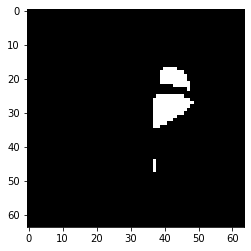

In [53]:
plt.imshow(final_patch_mask[0,:,:,52,0] , cmap = "gray")

In [54]:
# test_image_slices = test_img[:,(107-32):(107+32),(305-32):(305+32),(411-32):(411+32),:][0,:,:,32,0]
# test_mask_slices = test_mask[:,(107-32):(107+32),(305-32):(305+32),(411-32):(411+32),:]

In [55]:
# real_test_image_slices = test_img[:,(291-32):(291+32),(170-32):(170+32),(411-32):(411+32),:] / 2000
# real_test_mask_slices = test_mask[:,(291-32):(291+32),(170-32):(170+32),(411-32):(411+32),:] 

In [56]:
# plt.hist(real_test_image_slices.flatten())

In [57]:
# plt.hist(real_test_mask_slices.flatten())

When training with image -> divide by 2000

In [58]:
# plt.hist(test_image_slices.flatten())

# TODO: Scale this: divide by 2000 

# Hounsfield unit are -2000-2000 so it's a nice number

In [59]:
# plt.hist(test_mask_slices.flatten())

# TODO: Find patch of mask with airway voxels. 

In [60]:
train_ids = ["10004O", "10055F"]
# train_ids = ["10004O"]
valid_ids = ["10023S", "10032T"]
train_dir = "/home/jtabalon/airway_seg_data/train"
valid_dir = "/home/jtabalon/airway_seg_data/valid"

In [61]:
# og_train_gen = og_data_generator(ids, data_dir, batch_size=1, patch_size=64)
training_generator = data_generator(train_ids, train_dir, batch_size=1, patch_size=64)
valid_generator = data_generator(valid_ids, valid_dir, batch_size=1, patch_size=64)
# next(training_generator)

In [65]:
checkpoint_filepath = "/home/jtabalon/ckpt_airway_seg"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor="loss",
    # monitor="val_loss"
)

In [66]:
#model.fit(x=test_img, y=test_mask)
# model.fit(x=test_img[:,(107-32):(107+32),(305-32):(305+32),(411-32):(411+32),:], y=test_mask[:,(107-32):(107+32),(305-32):(305+32),(411-32):(411+32),:], epochs=100 ) # this is wrong lmao
# model.fit(x=patch_images[0], y=patch_labels[0], epochs=1000 )
model.fit(x=training_generator, \
#      validation_data=valid_generator, \
#      validation_batch_size=2, \
#      validation_freq=5, \
     steps_per_epoch=2, \
      epochs=1000,
      callbacks=[model_checkpoint_callback])

# model.fit(x=og_train_gen, steps_per_epoch=1, epochs=1000)
# model.fit(x=final_patch_img[0], y=final_patch_mask[0], epochs=1000 )

#model.fit(x = data_dict["10004O"]["patch_img"], y = [data_dict[patient_id]["patch_label"]], epochs=1000)


# TODO: add model checkpoint callback

Epoch 1/1000
2/2 [==============================] - 1s 620ms/step - loss: 0.9925


2022-03-26 17:54:50.506152: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/jtabalon/ckpt_airway_seg/assets
Epoch 2/1000
2/2 [==============================] - 1s 673ms/step - loss: 0.9747
INFO:tensorflow:Assets written to: /home/jtabalon/ckpt_airway_seg/assets
Epoch 3/1000
2/2 [==============================] - 1s 667ms/step - loss: 0.9908
Epoch 4/1000
2/2 [==============================] - 1s 669ms/step - loss: 0.8678
INFO:tensorflow:Assets written to: /home/jtabalon/ckpt_airway_seg/assets
Epoch 5/1000
2/2 [==============================] - 1s 659ms/step - loss: 0.7457
INFO:tensorflow:Assets written to: /home/jtabalon/ckpt_airway_seg/assets
Epoch 6/1000
2/2 [==============================] - 1s 666ms/step - loss: 0.8257
Epoch 7/1000
2/2 [==============================] - 1s 666ms/step - loss: 0.5956
INFO:tensorflow:Assets written to: /home/jtabalon/ckpt_airway_seg/assets
Epoch 8/1000
2/2 [==============================] - 1s 674ms/step - loss: 0.9747
Epoch 9/1000
2/2 [==============================] - 1s 667ms/step - 

KeyboardInterrupt: 

In [64]:
# TODO configure prediction section
#prediction = model.predict(test_img)

In [ ]:
# np.argmax(np.sum(prediction[0,:,:,:,0]))

0

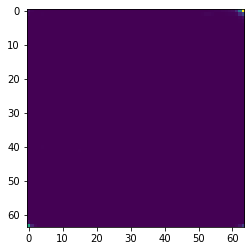

In [ ]:
plt.imshow(prediction[0,:,:,0,0])

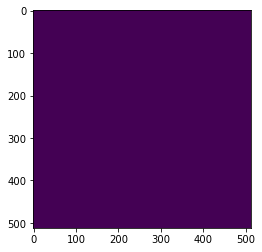

In [ ]:
# plt.imshow(test_mask[0,:,:,32,0])